# 请求与响应

- 本部分内容是涉及ScraPy中请求与响应的话题。为了便于展开这部分的内容，我们使用`知乎、百度翻译、拉勾网`作为例子背景。本部分所有链接来自知乎。
    - 创建爬虫：`scrapy genspider -t basic zhihu_request  www.zhihu.com`
    
- Request与Response牵涉比较底层一点的技术：网络编程与HTTP协议。

## Request的API说明

```python

    class scrapy.http.Request(url[, callback, method='GET', headers, body, cookies, meta, encoding='utf-8', priority=0, dont_filter=False, errback, flags])
    
        |- url               字符串：请求的页面URL
        |- callback       函数名：URL下载完毕后的回调处理函数
        |- method        字符串：请求页面的方法，常用的有GET，POST，PUT等。
        |- headers        字典：发起请求的HTTP头，用来告诉Web服务器一些请求信息。
        |- body            字典：发起请求的数据体，一般是对POST方法使用。其他方法都在用QueryString。
        |- cookies        字典：发送给Web服务器的数据，属于特殊的HEADER。
        |- meta            字典：是ScraPy定义的一些有意义的元数据，可以影响爬取的行为。 
        |- encoding      字符串：请求过程使用的编码，影响发哦下载页面的编码以及URL解析的编码等。  
        |- priority         整数：请求的优先级，值越大，越优先处理（这影响到调度器处理的优先级），可以为负数，表示优先级很低。 
        |- dont_filter     逻辑值：告诉调度器，不要过滤本请求（调度器会自动过滤重复的URL）   
        |- errback        函数名：请求发生错误的回调处理函数
        |- flags            列表：用于一些特殊的目的，比如日志处理。

```

- 下面采用知乎登录来说明Request与Response的使用
    - 知乎登录流程
        - 进入主页，弹出登录框：GET：`https://www.zhihu.com/signup?next=/`
        - 得到用户识别id：POST：`https://www.zhihu.com/udid`
        - 判定是否需要校验：GET：`https://www.zhihu.com/api/v3/oauth/captcha?lang=en`
            - 需要校验，下载校验码：PUT：`https://www.zhihu.com/api/v3/oauth/captcha?lang=en`
            - 验证校验码：（同上）POST：`https://www.zhihu.com/api/v3/oauth/captcha?lang=en`
        - 验证登录用户与密码：POST：`https://www.zhihu.com/api/v3/oauth/sign_in`


## Request使用：发起知乎登录第一次请求

- 相关知识点
    - method的使用：
        - GET方法使用
    - headers的使用
    - url
    - callback
    - encoding
    - priority
    - dont_filter
    - errback

1. 准备
    - 原来默认直接从start_urls开始，并调用parse函数解析。
    - 实际Spider的执行是从Spider的start_requests(self)函数开始的。

2. 重载start_request发起第一次请求
    - 一般不会使用这么多参数，大部分参数使用缺省值就足够。

```python

# -*- coding: utf-8 -*-
import scrapy


class ZhihuRequestSpider(scrapy.Spider):
    name = 'zhihu_request'
    allowed_domains = ['www.zhihu.com']
    start_urls = [
        'https://www.zhihu.com/signup?next=%2F',
        'https://www.zhihu.com/udid',
        'https://www.zhihu.com/api/v3/oauth/captcha?lang=en',
        'https://www.zhihu.com/api/v3/oauth/sign_in'
    ]
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/12.0.3 Safari/605.1.15'
    }

    def start_requests(self):
        # 发起第一个请求
        home_request = scrapy.Request(
            url=self.start_urls[0],
            callback=self.process_home,
            method='get',
            headers=self.headers,
            cookies='',
            encoding='utf-8',
            priority=0,
            dont_filter=True,
            errback=self.handle_error
        )
        return [home_request]

    def process_home(self, response):
        print('处理数据')

    def handle_error(self, failure):
        print('处理错误')

```

3. 注意：
    - 第一次请求的start_requests不能返回None
    - start_requests必须返回可迭代的，比如list类型，或者生成器类型。
    
    - 上面的运行结果：
        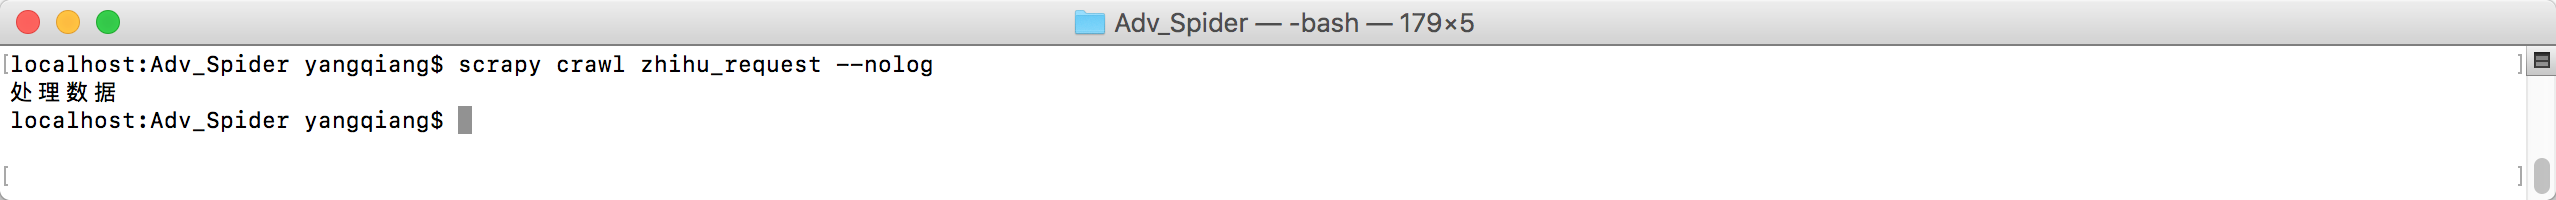

## Response的API说明

```python 

    class scrapy.http.response.Response(url[, status=200, headers=None, body=b'', flags=None, request=None])
        |- url (string) – the URL of this response
        |- status (integer) – the HTTP status of the response. Defaults to 200
        |- headers (dict) – the headers of this response. The dict values can be strings (for single valued headers) or lists (for multi-valued headers).
        |- body (bytes) – the response body. To access the decoded text as str (unicode in Python 2) you can use response.text from an encoding-aware Response subclass, such as TextResponse.
        |- flags (list) – is a list containing the initial values for the Response.flags attribute. If given, the list will be shallow copied.
        |- request (Request object) – the initial value of the Response.request attribute. This represents the Request that generated this response.
        
        |
        |- replace([url, status, headers, body, request, flags, cls])
        |- urljoin(url)   # 使用response的url与相对的url，构造一个新的绝对URL。
        |- follow(url, callback=None, method='GET', headers=None, body=None, cookies=None, meta=None, encoding='utf-8', priority=0, dont_filter=False, errback=None)   # 返回一个新的Request，可以使用相对URL。

```

## TextResponse的API说明

```python

    class scrapy.http.response.text.TextResponse(url[, encoding[, ...]])
        |- encoding：encoding (string) – is a string which contains the encoding to use for this response. you create a TextResponse object with a unicode body, it will be encoded using this encoding (remember the body attribute is always a string). If encoding is None (default value), the encoding will be looked up in the response headers and body instead.
        |- selector
        |- xpath(query)
        |- css(query)
        |- body_as_unicode()

```

## HtmlResponse的API说明

```python
    class HtmlResponse(scrapy.http.response.text.TextResponse)
         |-  Inherit from this class (instead of object) to a keep a record of live instances
         |  
         |-  Method resolution order:
         |      - HtmlResponse
         |      - scrapy.http.response.text.TextResponse
         |      - scrapy.http.response.Response
         |      - scrapy.utils.trackref.object_ref
         |      - builtins.object
```

## Response的使用：得到知乎第一次请求的响应

- xpath与css在全面已经使用过，是Response的核心解析功能函数。
- 下面主要讲解Response的header。

- 代码：

```python

    def process_home(self, response):
        print(type(response))
        print('url', response.url)
        print('status', response.status)
        print('headers', response.headers)
        print('flags', response.flags)
        # print('body', response.body)
        print('request', response.request)
        # 注意request的cookie
        print('request.cookies',response.request.cookies)
        print('request.headers', response.request.headers)

```

- 运行效果
    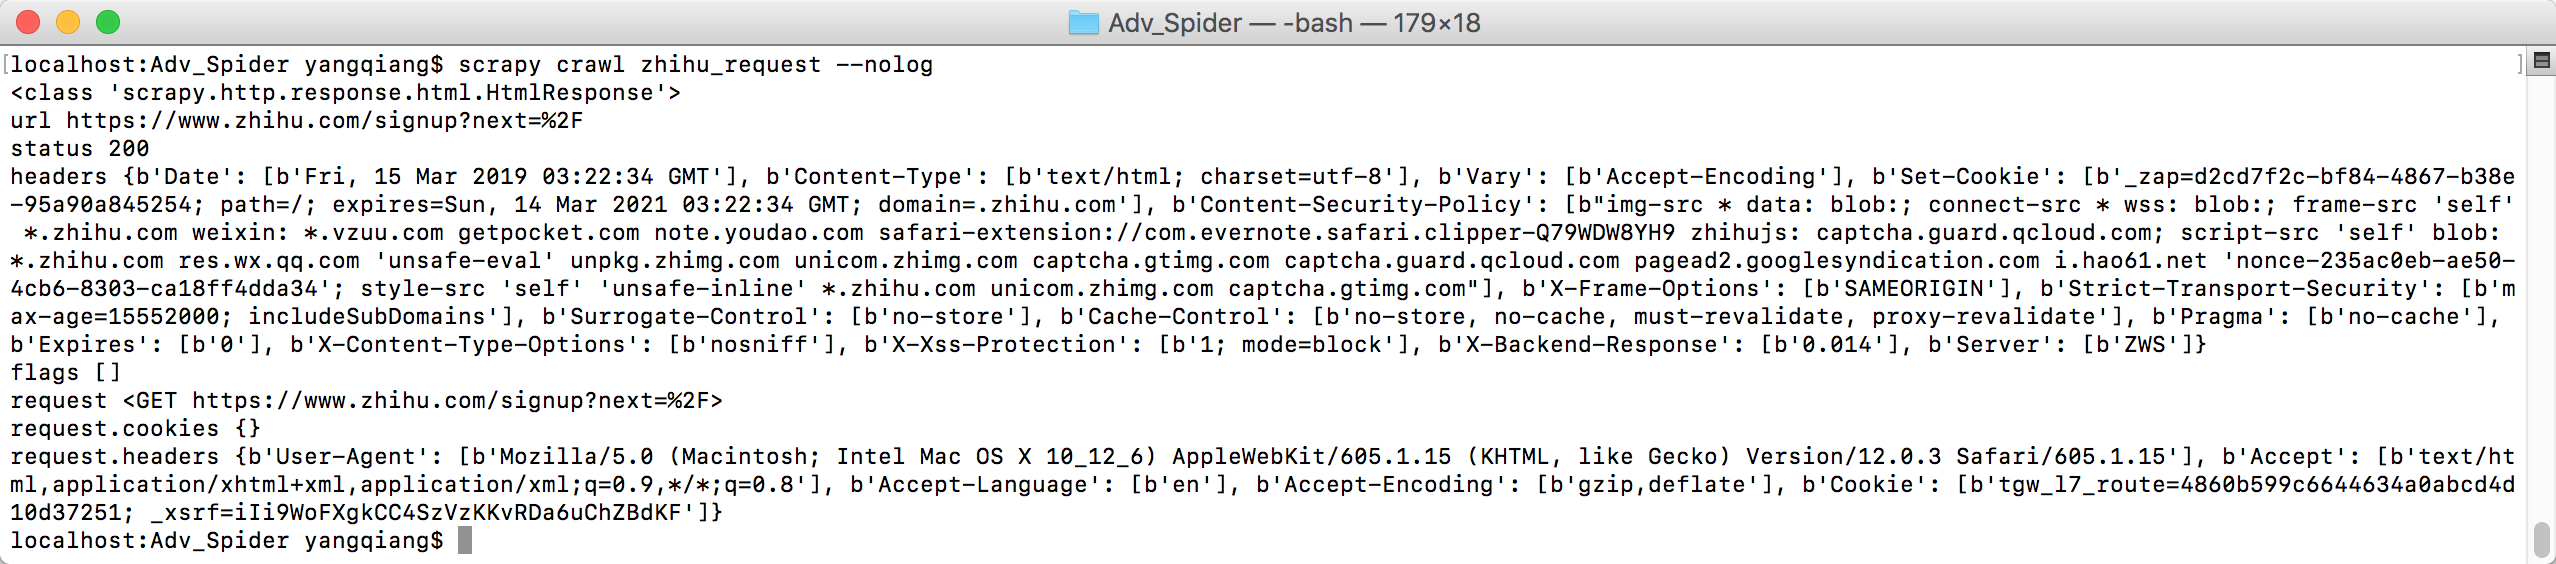
    
- 注意headers中的set-cookies与status。

## 使用POST发起Request请求与错误处理

1. 发起请求的代码
    - 为了构造一个错误条件，我们故意没有设置headers。

```python

    def process_home(self, response):

        if response.status == 200:
            uuid_request = scrapy.Request(
                url=self.start_urls[1],
                callback=self.process_udid,
                method='post',
                dont_filter=True,
                errback=self.handle_error
            )
            return [uuid_request]
```

2. 产生的错误
    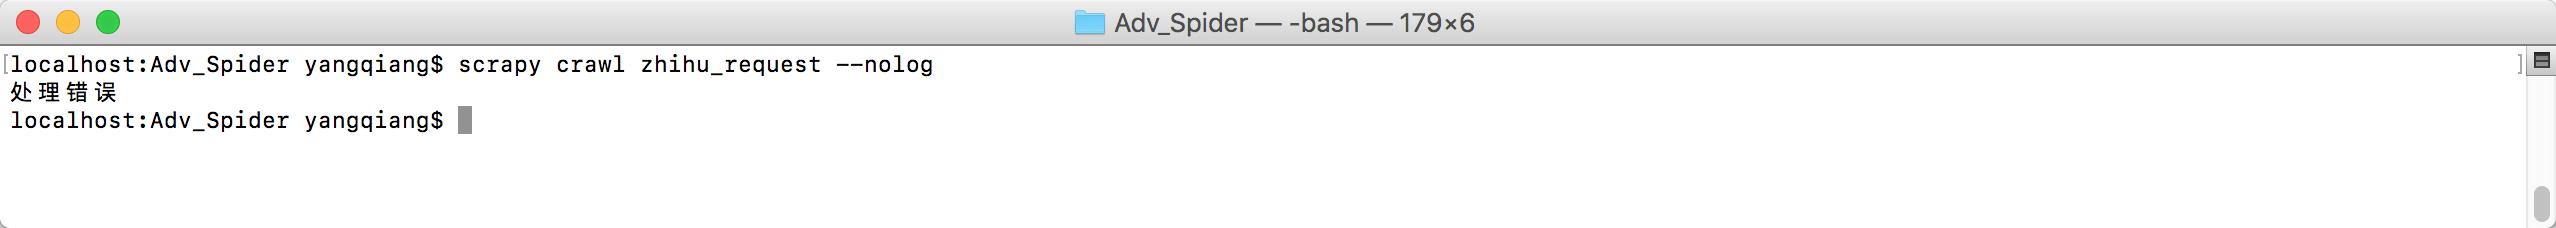

3. Failure的API说明：

- 在ScraPy框架只能给错误由`twisted.python.failure.Failure`封装实现。

```python

    class Failure(builtins.BaseException)
        |  A basic abstraction for an error that has occurred.
        
        |  @ivar value: The exception instance responsible for this failure.
        |  @ivar type: The exception's class.
        |  @ivar stack: list of frames, innermost last, excluding C{Failure.__init__}.
        |  @ivar frames: list of frames, innermost first.
    
    
        |- check(self, *errorTypes)   检测是否是某个错误发生
        |- 
        |- getBriefTraceback(self)
        |  
        |- getErrorMessage(self)
        |      Get a string of the exception which caused this Failure.
        |  
        |- getTraceback(self, elideFrameworkCode=0, detail='default')
        |  
        |- getTracebackObject(self)
        | 
        |- printBriefTraceback(self, file=None, elideFrameworkCode=0)
        |      Print a traceback as densely as possible.
        |  
        |-  printDetailedTraceback(self, file=None, elideFrameworkCode=0)
        |      Print a traceback with detailed locals and globals information.
        |  
        |-  printTraceback(self, file=None, elideFrameworkCode=False, detail='default')
        |      Emulate Python's standard error reporting mechanism.

```

- 其中的错误类型是：`scrapy.spidermiddlewares.httperror.HttpError`
    - 可以通过HttpError获得真实的响应对象response


4. 代码

```python

    def handle_error(self, failure):
        print('处理错误', failure.getErrorMessage())
        print(failure.getTraceback())
        print(type(failure.value))
        print(type(failure.type))
        print(type(failure.stack))
        print(type(failure.frames))
        print(failure.value.response.status)
        print(failure.request)
        print(dir(failure))

```

- 运行结果
    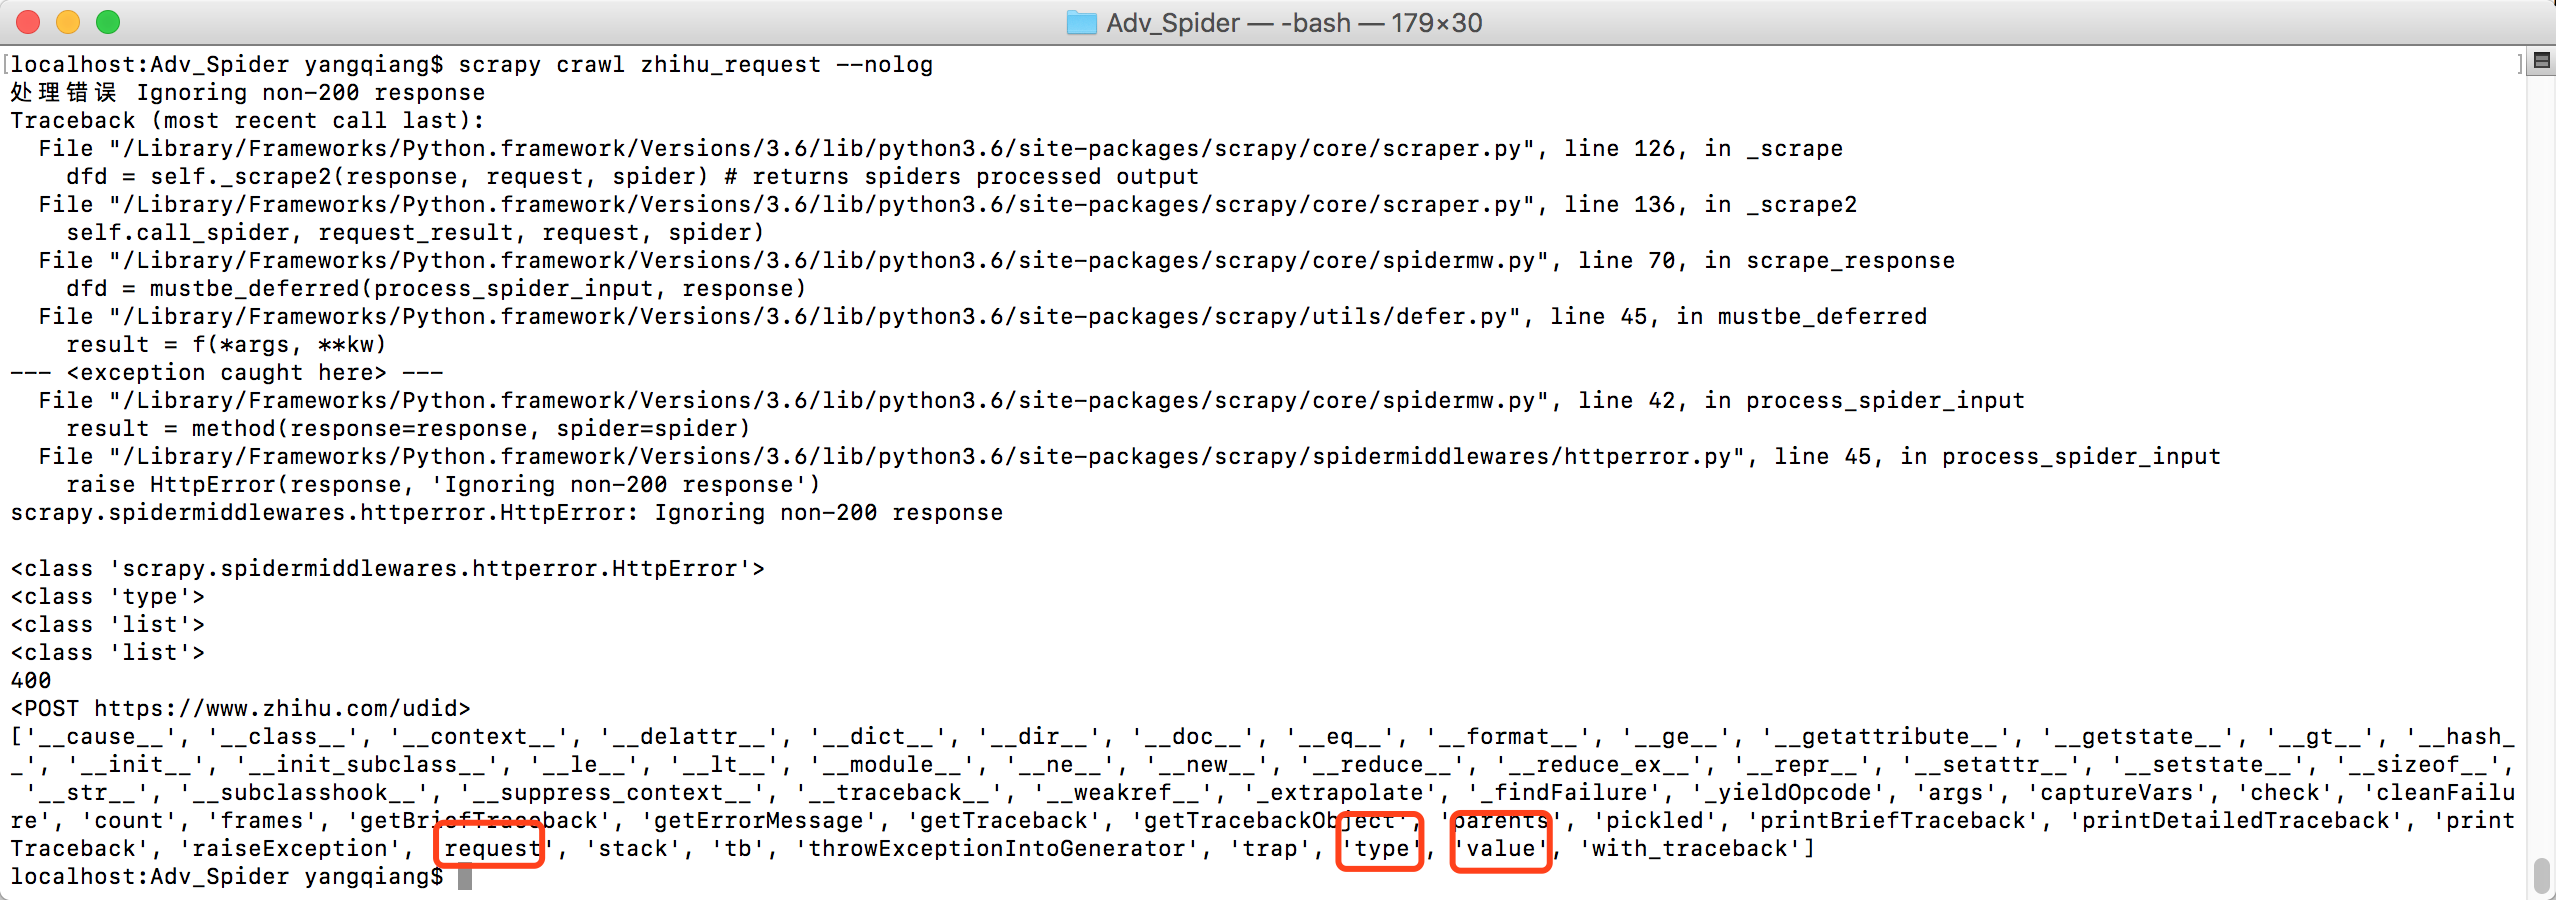

5. 设置headers，解决错误

```python

    def process_home(self, response):

        if response.status == 200:
            uuid_request = scrapy.Request(
                url=self.start_urls[1],
                callback=self.process_udid,
                headers=self.headers,                  # <-------注意这行代码
                method='post',
                dont_filter=True,
                errback=self.handle_error
            )
            return [uuid_request]



    def process_udid(self, response):
        print('udid处理',response)
        if response.status == 200:
            print('开始发起是否需要校验码的请求')

```
- 运行效果如下：
    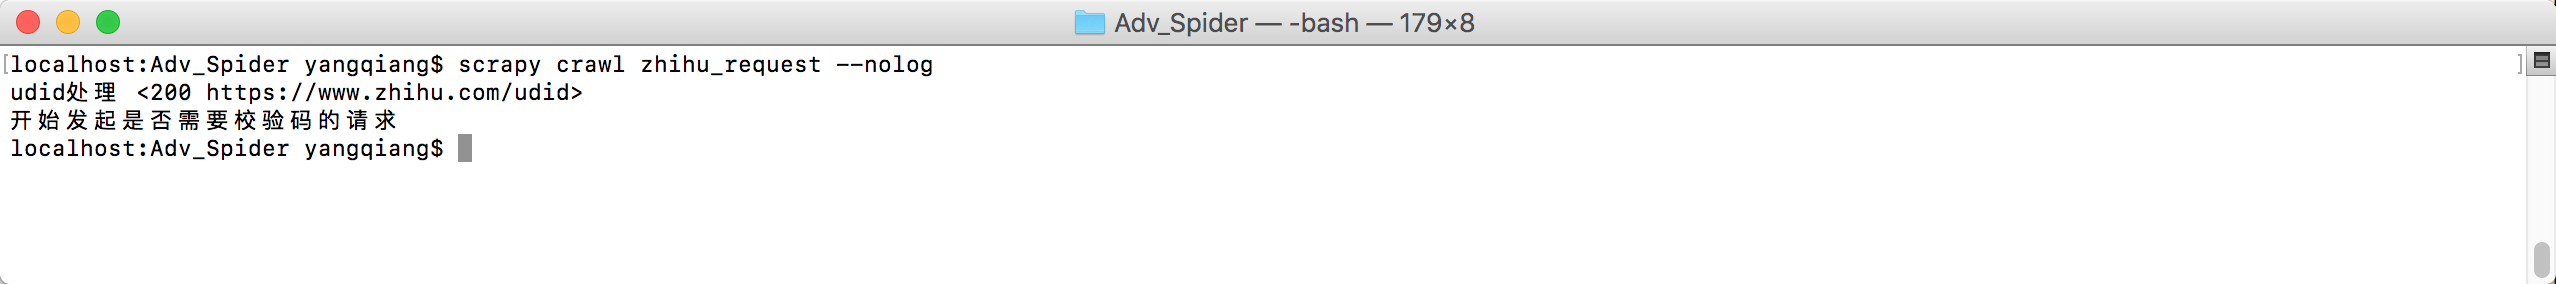

## 使用get方法发起是否需要校验的判定
    
- 使用方式与上面一样，返回的是json数据

1. 代码

```python

    def process_udid(self, response):
        print('udid处理',response)
        if response.status == 200:
            print('查询校验码')
            is_captcha_request = scrapy.Request(
                url=self.start_urls[2],
                callback=self.query_is_captcha,
                headers=self.headers,
                method='get',
                dont_filter=True,
                errback=self.handle_error
            )
            return [is_captcha_request]

    def query_is_captcha(self, response):
        print('处理是否需要校验', response)
        print('状态码：', response.status)
        json_is_captcha = json.loads(response.body)
        if json_is_captcha['show_captcha']:
            print('下载校验码校验（put），并校验（post）')

        else:
            print('开始直接登录')
            print('发起登录请求')

```

- 运行效果：
    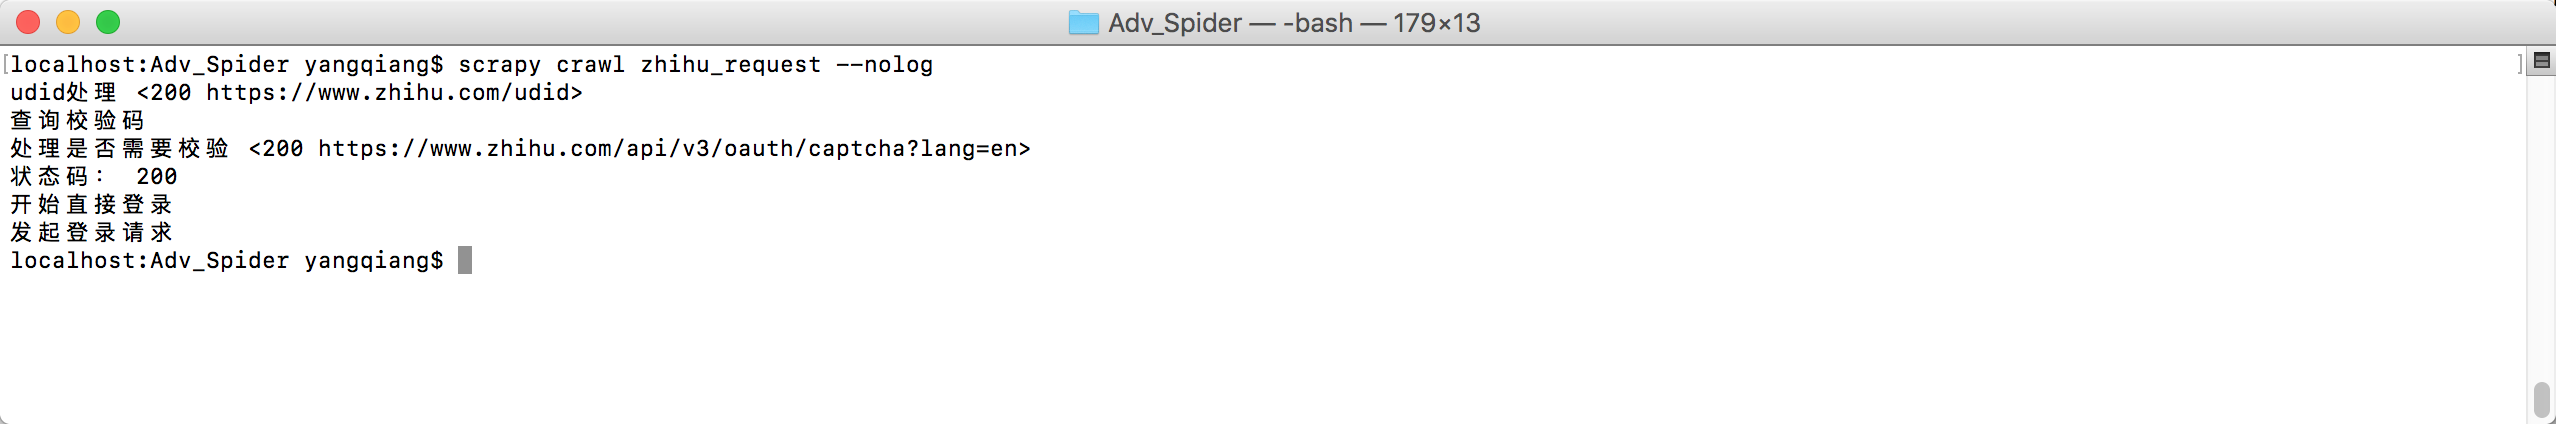

## 发起登录请求


- 由于登录用到两个技术，这里不讲原理，直接给出：
    - 签名生成技术
    - 用户名与口令加密技术
    

### 签名生成函数实现

- 根据四个信息生成签名
    - grant_type：password                                        -授权类型
    - client_id：c3cef7c66a1843f8b3a9e6a1e3160e20    - 客户ID
    - source：com.zhihu.web                                      - 访问源             
    - now：                                                               - 当前时间 

```python

    # 签名函数
    def get_signature(self, now_):
        # 签名由clientId,grantType,source,timestamp四个参数生成
        h = hmac.new(
            key='d1b964811afb40118a12068ff74a12f4'.encode('utf-8'),
            digestmod=sha1)
        grant_type = 'password'
        client_id = 'c3cef7c66a1843f8b3a9e6a1e3160e20'
        source = 'com.zhihu.web'
        now = now_
        h.update((grant_type + client_id + source + now).encode('utf-8'))
        return h.hexdigest()
```

### 登录信息加密实现
- 调用知乎自己的js脚本（该脚本通过浏览器调试得到，并且做了一些修改）
- js文件比较多，这里不列出。

```python
    # 提交信息加密函数
    def get_encrypt(self, username, password, timestamp, signature, captcha):
        str_login = ""
        str_login += "client_id=c3cef7c66a1843f8b3a9e6a1e3160e20&"
        str_login += "grant_type=password&"
        str_login += F"timestamp={timestamp}&"
        str_login += "source=com.zhihu.web"
        str_login += F"&signature={signature}&"
        str_login += F"username={username}&"
        str_login += F"password={password}&"
        str_login += F"captcha={captcha}&"
        str_login += "lang=en&"
        str_login += "ref_source=homepage&"
        str_login += "utm_source="

        with open('p05_custom_atob.js', 'r') as fd:
            js_zhihu = fd.read()

        ctx = execjs.compile(js_zhihu)
        encrypt_ = ctx.call('Q', str_login)
        return encrypt_

```


### 发起登录请求
    
- 发起登录请求，需要准备登录数据
    - 生成签名
    - 加密信息
    
- 实现代码

```python

    def query_is_captcha(self, response):
        print('处理是否需要校验', response)
        print('状态码：', response.status)
        json_is_captcha = json.loads(response.body)
        if json_is_captcha['show_captcha']:
            print('下载校验码校验（put），并校验（post）')

        else:
            print('开始直接登录')
            print('发起登录请求')
            # 创建签名
            # 加密信息
            timestamp = str(int(time.time() * 1000))
            signature = self.get_signature(timestamp)
            encrypt = self.get_encrypt('******', '********', timestamp, signature, '')      # 自己填充知乎账号与密码
            print(encrypt)
            data = encrypt

            # 数据没有采用字典，而是直接使用body

            login_request = scrapy.Request(
                url=self.start_urls[3],
                callback=self.process_login,
                headers=self.headers,
                method='post',
                body=data,                      #   <------注意这个data，以及上面head中的content-type头的设置
                dont_filter=True,
                errback=self.handle_error
            )
            return [login_request]

    def process_login(self, response):
        print('登录处理')
        print('登录状态：', response.status)

```

- 运行结果
    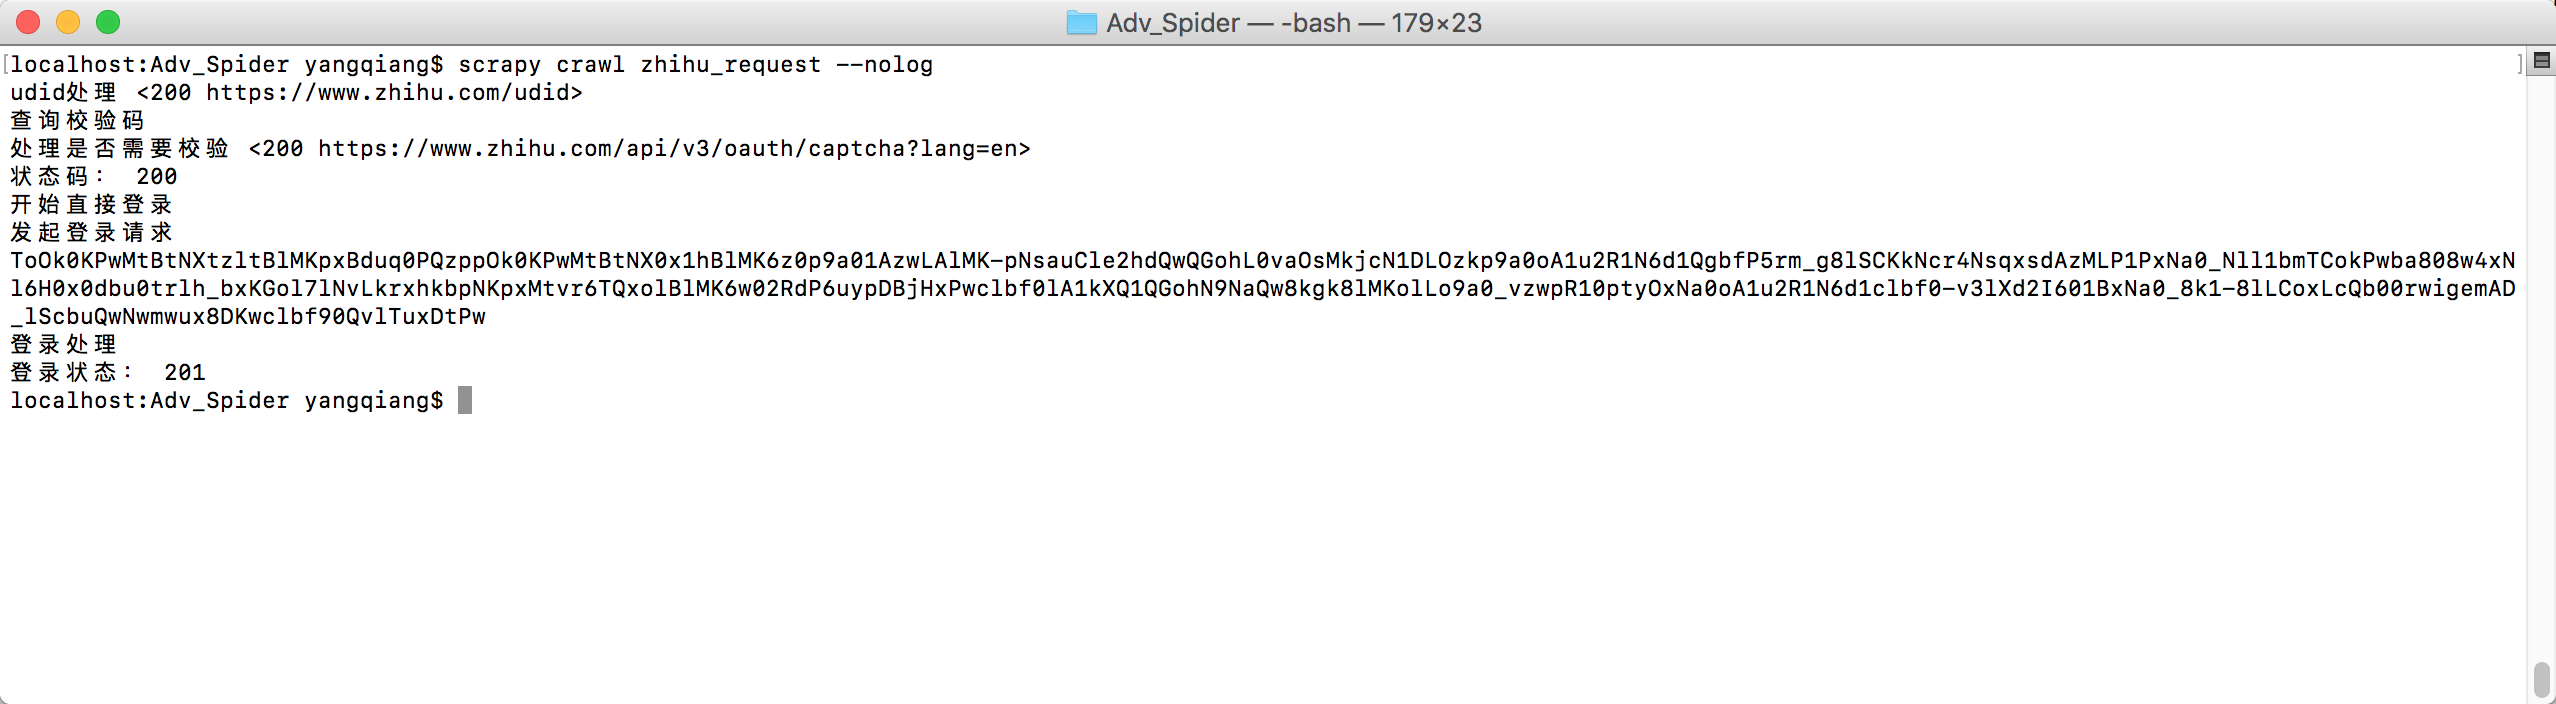
    

- 说明：
    - 上面登录成功返回的不是200状态码，而是201，表示希望用户需要继续发起请求，这就是通常登录成功直接跳转到首页，或者个人中心。下面的处理就比较简单了。

## Request.meta


- 下面是请求的元 ，其含义与字面意思一样，注意的是：很多meta都有同等的setting设置。
    - |- dont_redirect
    - |- dont_retry
    - |- handle_httpstatus_list
    - |- handle_httpstatus_all
    - |- dont_merge_cookies
    - |- cookiejar
    - |- dont_cache
    - |- redirect_urls
    - |- bindaddress
    - |- dont_obey_robotstxt
    - |- download_timeout
    - |- download_maxsize
    - |- download_latency
    - |- download_fail_on_dataloss
    - |- proxy
    - |- ftp_user (See FTP_USER for more info)
    - |- ftp_password (See FTP_PASSWORD for more info)
    - |- referrer_policy
    - |- max_retry_times


## 请求的cookie与session

1. Request的Session是由Cookie来实现的，在ScraPy框架中Cookie由两种方式发送：
    - 在Request中使用cookie参数发送。可以发送字典列表，也可以发送字典。
    - 当某些站点的响应返回cookie时，这些cookie存储在该域的cookie中，并将在下次的请求中发送。但是，如果出于某种原因，您希望避免与现有cookies合并，您可以通过在request.meta中将“不合并cookies”键设置为true来指示scrapy这样做。
    

2. cookies的使用方式 - 字典方式

```python

    request_with_cookies = Request(url="http://www.example.com",
                               cookies={'currency': 'USD', 'country': 'UY'})

```


3. cookies的使用方式 - 字典列表方式

```python

    request_with_cookies = Request(url="http://www.example.com",
                               cookies=[{'name': 'currency',
                                        'value': 'USD',
                                        'domain': 'example.com',
                                        'path': '/currency'}])

```

4. 防止Request中cookies与Site存储的cookies合并

```python

    request_with_cookies = Request(url="http://www.example.com",
                               cookies={'currency': 'USD', 'country': 'UY'},
                               meta={'dont_merge_cookies': True})

```



        

## FormRequest表单请求

- 这个类用来构造一个POST请求，请求体使用表单数据；

- 还可以从一个返回的响应来构造FormRequest对象。
    - `classmethod from_response(response[, formname=None, formid=None, formnumber=0, formdata=None, formxpath=None, formcss=None, clickdata=None, dont_click=False, ...])`
    
    
    - 这个方法用来做自动注册特别好，不过现在都有校验码，使用这种单一的方式，就需要额外的处理了，这里不举例子。


### FormRequest的API说明

- 该类继承Request ，只是构造器增加了一个字典或者元组迭代类型的表单数据参数。

```python
    class scrapy.http.FormRequest(url[, formdata, ...])
    
        | - formdata (字典 or iterable of tuples) 

```

### 使用FormRequest实现表单数据提交

- 下面使用百度翻译来说明表单提交。
    - Request提交表单，需要两个事情：
        - 需要转换成Body格式，这要求必须知道HTTP中表单的数据格式；
        - 必须告诉服务表单的格式：`'content-type': 'application/x-www-form-urlencoded'`
        
    - Form提交表单，只需要指定字典或者元组可迭代数据即可（一般使用字典）。
    

1. Request的请求方式

```python

     # Request
        headers = {
           'content-type': 'application/x-www-form-urlencoded',
        }
        trnaslator_1 = scrapy.Request(
            url=self.start_urls[0],
            callback=self.get_translate,
            method='POST',    # 官方文档说需要大小，实际大小写都没有问题
            headers=headers,      # --> 指定表单格式
            dont_filter=True,           # 同一个请求url，防止被过滤
            body='kw=test'.encode())    # 使用body提交，必须手工指定表单格式

```

2. Form的请求方式

```python

        # FormRequest
        form = {
            'kw': 'test'
        }
        trnaslator_2 = scrapy.FormRequest(
            url=self.start_urls[0],
            callback=self.get_translate,
            dont_filter=True,
            formdata=form)    # 不适合使用表单提交

```

3. 完整的代码：

```python

    # -*- coding: utf-8 -*-
import scrapy
import scrapy.http
import json

class BaiduRequestSpider(scrapy.Spider):
    name = 'baidu_request'
    allowed_domains = ['fanyi.baidu.com']
    start_urls = ['https://fanyi.baidu.com/sug']



    def start_requests(self):
        # Request
        headers = {
           'content-type': 'application/x-www-form-urlencoded',
        }
        trnaslator_1 = scrapy.Request(
            url=self.start_urls[0],
            callback=self.get_translate,
            method='POST',    # 官方文档说需要大小，实际大小写都没有问题
            headers=headers,      # --> 指定表单格式
            dont_filter=True,           # 同一个请求url，防止被过滤
            body='kw=test'.encode())    # 使用body提交，必须手工指定表单格式

        # FormRequest
        form = {
            'kw': 'test'
        }
        trnaslator_2 = scrapy.FormRequest(
            url=self.start_urls[0],
            callback=self.get_translate,
            dont_filter=True,
            formdata=form)    # 不适合使用表单提交

        return [trnaslator_1, trnaslator_2]


    def get_translate(self,response):
        print('--------------------')
        result = json.loads(response.text)
        print(result)


```

4. 运行的结果
    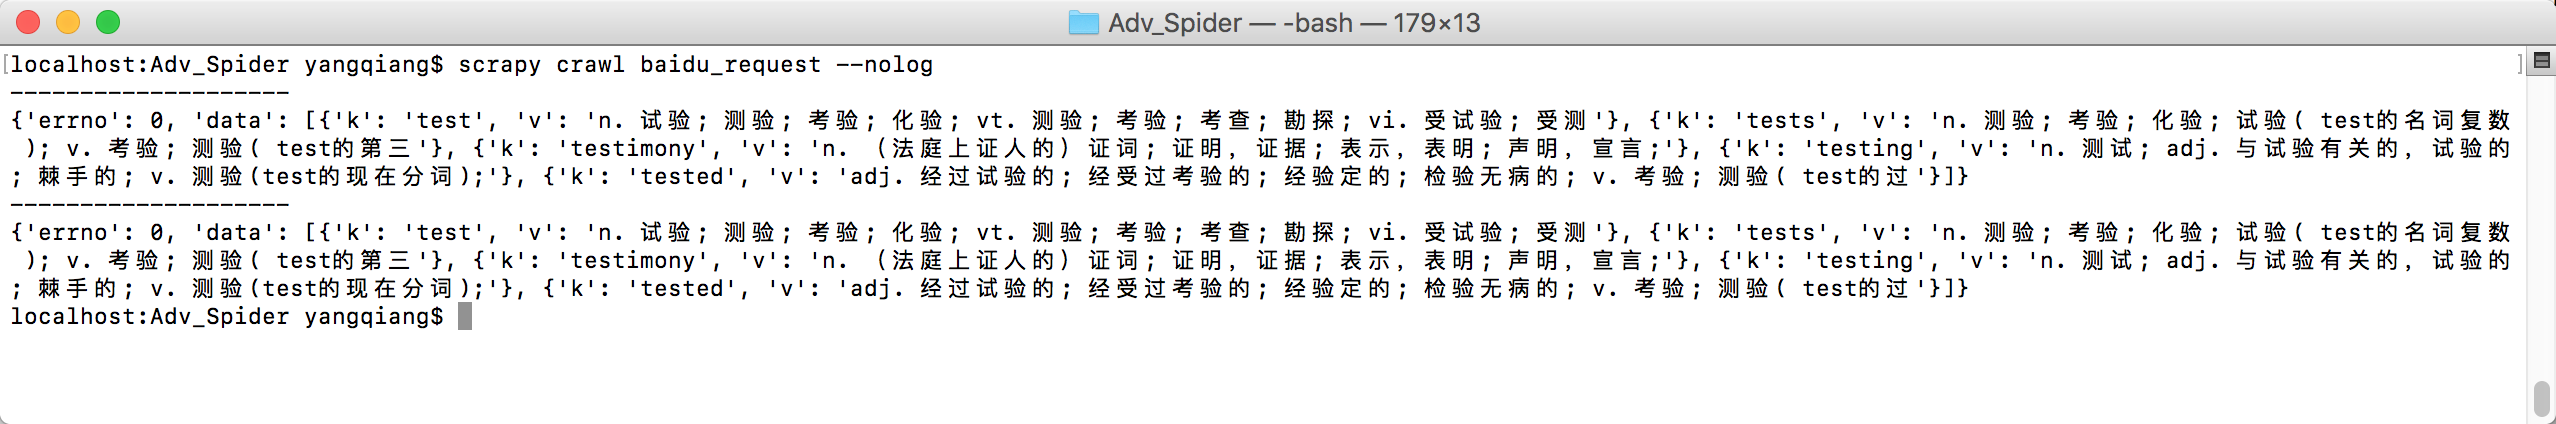
    
    上述数据可以自己使用json格式解析。

## 其他格式的Response

- 其他格式的Response基本上大同小异：
    - TextResponse
        - |- HtmlResponse
        - |- XmlResponse 